# Pruebas de codigo con [OpenAir](https://davidcarslaw.github.io/openair/reference/index.html) y [Saqgetr](https://github.com/skgrange/saqgetr)

> [Configuracion del notebook](#config)
>
> [Leer los datos de fichero](#read)
>
> [Estaciones de españa](#espanha)
>    * [Datos de las estaciones de ```saqgetr```](#estacionesSaqgetr)
>    * [Datos geograficos de las estaciones](#estacionGeo)
>
> [Estudio de los Datos](#stdio)
>    * [Resolucion de 1 dia](#resody)
>    *   [x] [Probando otra forma](#prueba)
>    * [Resolucion de 1 semana](#resowk)
>    * [Resolucion de 1 mes](#resoms)
>
> [Analisis de los Datos](#analyData)
>    * [Theil-Sen function](#theilSen)
>    * [funcion `lm`](#lm)
>
>[Guardas Datos en xlsx](#save)

## Configuracion del notebook <a id="config"></a>

Ajustes especificos para controlar la apariencia de las graficas en jupyter lab

In [1]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

Cargamos todos los paquetes necesarios para ejecutar el notebook

In [2]:
suppressMessages(library(saqgetr))
suppressMessages(library(tidyverse))
suppressMessages(library(lubridate))
suppressMessages(library(worldmet))

# En lugar de cargar el paquete openair se utiliza el ggopenair,
# otro paquete desarrollado por el mismo que Openair con el objetivo de 
# utilizar ggplot2 en lugar de lattice para la representaciones graficas
#
#suppressMessages(library(openair))
suppressMessages(library(ggopenair)) 


suppressMessages(library(gridExtra))
suppressMessages(library(mblm))

Inicializamos ciertas variables con los parametros de estudio

In [3]:
# contaminantes a estudiar
pollutants <- c("no", "no2", "o3", "pm10")

# fechas de inicio y final de toma de datos
start_dt <- ymd_hms("2015-01-01 00:00:00")
end_dt <- ymd_hms("2020-10-01 00:00:00")

# fecha de inicio de confinamiento
lckdwn_strt <- ymd_hms("2020-03-14 00:00:00")

## Leer los datos de fichero <a id="read"></a>

Se pueden extraer directamente los datos ya seleccionados de las estaciones de estudio y los datos de la calidad del aire de los archivos `../data/csv/dataAQV.csv` y `../data/csv/estaciones.csv` respectivamente. Si no se tienen dichos archivos o se quieren modificar los parametros de estudio se ejecutara la seccion [Estaciones de España](#espanha)

``` R
if (file.exists("../data/csv/estaciones.csv")) {
    sites <- read.csv("../data/csv/estaciones.csv")
}
head(sites)
```

``` R
if (file.exists("../data/csv/dataAQV.csv")) {
    dataAQV <- read.csv("../data/csv/dataAQV.csv")
    
    # Convert date to datetime format
    dataAQV$date <- ymd_hms(dataAQV$date)
}
head(dataAQV)
```

## Estaciones de España <a id="espanha"></a>

### Datos geograficos de las estaciones <a id="estacionGeo"></a>

Seleccionamos aquellas estaciones que se encuentren en un núcleo con una
población mayor o igual a cien mil habitantes `poblacion >= 100 000 hab`.

En la hoja 8 `ciudades-100000-A-JA` de la base de datos de poblaciones (`estaciones-CA.xlsx`) aparecen todas las estaciones de trafico de las ciudades de mas de 100000 habitantes con sus nombres.

In [4]:
# Loading
library("readxl")

file <- "../data/xlsx/estaciones-CA-JA.xlsx"
sheets <- c("todas", "traffic", "traffic-urban", "traffic-urban-2020",
            "traffic-suburban", "traffic-suburban-2020",
            "ciudades-100000", "ciudades-100000-A")
# xlsx files
sites.100mil <- read_excel(file, sheet=sheets[8])

In [5]:
head(sites.100mil)

Municipio         Población Estación tráfico  Código estación
1 A Coruña          245711    CORLAB 1          es1138a        
2 Alcalá de Henares 195649    Alcalá de Henares es1563a        
3 Alcobendas        117040    Alcobendas        es1564a        
4 Alicante          334887    Florida-Babel     es1915a        
5 Alicante          334888    ALACANT-EL PLÁ    es1635a        
6 Almería           198533    MEDITERRÁNEO      es1393a        
  Nº estaciones Ecolog Nº estaciones tráfico
1 4                    1                    
2 0                    1                    
3 0                    1                    
4 3                    1                    
5 3                    1                    
6 0                    1                    
  Observaciones                                                       
1 Es Riazor o Santa Margarida, revisar. Datos sólo hasta 2018. REVISAR
2 NA                                                                  
3 NA                                                                  
4 Urban background. Not traffic                                       
5 Esta es de tráfico                                                  
6 NA

### Datos de las estaciones de `saqgetr` <a id="estacionesSaqgetr"></a>

Importamos la informacion de las estaciones de calidad de aire de españa obtenidas de la base de datos y filtramos segun los criterios de estudio.

| Variable | Valores |
|-------|-----------|
|Contaminantes| $NO$, $NO_2$, $O_3$, $PM_{10}$|
|Fecha Inicio| 01 Enero 2015 |
|Fecha Final | 31 Diciembre 2020 |
| Site Type | traffic |
|site area | urban |

In [6]:
# obtener datos de CA de España. Salen los códigos de las estaciones
# de Calidad de aire (941)
spain.sites <- get_saq_sites() %>%
    filter(country == "spain",
           site %in% sites.100mil$"Código estación",
           site_type == "traffic",
           site_area == "urban",
           date_start <= start_dt,
           date_end >= end_dt,
           )

In [7]:
removed.sites <- nrow(sites.100mil) - nrow(spain.sites)

print(paste("Se han eliminado", removed.sites, "estaciones"))
print(paste("Quedan", nrow(spain.sites), "estaciones para el estudio"))

[1] "Se han eliminado 14 estaciones"
[1] "Quedan 65 estaciones para el estudio"


Agrupamos en un solo data.frame toda la informacion relevante de las estaciones de estudio

In [8]:
sites.info <- get_saq_processes() %>%
    filter(site %in% spain.sites$site,
           variable %in% pollutants,
           date_start <= start_dt,
           #date_end >= end_dt,
          ) %>%
    select(site, variable, period, unit, date_start, date_end)

sites.geo <- sites.100mil %>%
    select("Municipio", "Población", 
           "Estación tráfico", "Código estación") %>%
    rename(site = "Código estación",)

sites <- merge(x = sites.info, y = sites.geo, by = "site", all.x = TRUE)
head(sites)

site    variable period unit   date_start date_end            Municipio
1 es0041a no2      day    ug.m-3 1987-04-01 1987-08-31 00:00:00 Bilbao   
2 es0110a o3       day    ug.m-3 1997-01-01 2009-12-31 00:00:00 Bilbao   
3 es0110a o3       dymax  ug.m-3 1997-01-01 2009-12-31 00:00:00 Bilbao   
4 es0110a o3       hour   ug.m-3 1997-01-01 2009-12-31 23:00:00 Bilbao   
5 es0110a o3       hour8  ug.m-3 1997-01-01 2009-12-31 23:00:00 Bilbao   
6 es0110a no2      day    ug.m-3 1997-01-10 2011-12-31 00:00:00 Bilbao   
  Población Estación tráfico  
1 346843    María Diaz de Haro
2  24350    Erandio           
3  24350    Erandio           
4  24350    Erandio           
5  24350    Erandio           
6  24350    Erandio

## Estudio de los Datos <a id="stdio"></a>

In [9]:
suppressMessages(dataAQV <- get_saq_observations(
    site = levels(as.factor(sites$site))[2:5],
    variable = pollutants,
    valid_only = TRUE,
    start = start_dt,
    end = end_dt,
    verbose = TRUE
))


El paquete `saqgetr` nos permite 'limpiar' los datos, obteniendo directamente los datos con una resolucion horaria o diaria. Ademas, esta funcion permite mediante el atributo `spread=False` remodelar el dataframe pivotando las columnas `variable` y `value`, obteniendo un dataframe con los contamiantes por columna.

$$
\begin{vmatrix}
\textbf{site} & \textbf{variable} & \textbf{value} \\
es123a & no2 & 20.323 \\ 
es123a & 03 & 40.545 \\ 
es123a & pm10 & 60.323 \\ 
... & ... & ... \\ 
\end{vmatrix}
\Rightarrow
\begin{vmatrix}
\textbf{site} & \textbf{no2} & \textbf{03} & \textbf{pm10} \\
es123a & 20.323 & 40.545 & 60.323 \\ 
es123a & 20.323 & 40.545 & 60.323 \\ 
es123a & 20.323 & 40.545 & 60.323 \\ 
... & ... & ... & ... 
\end{vmatrix}
$$

``` R
dataAQV.cln <- saq_clean_observations(dataAQV,
                                      summary = "hour",
                                      #valid_only = TRUE,
                                      #spread = TRUE,
                                     )
```

No obstante, no te permite trabajar con otra resolucion que no sea horaria o diaria por lo que he creado dos funciones `pivot.by.pollut` y `group.by.date` para obtener las mismas transformaciones pero con la resolucion que quiera. Esto lo he hecho solo con el objetivo de familiarizarme con los datos.

Las funciones se pueden encontrar en el script `../src/funciones.R`

In [10]:
source("../src/funciones.R")

### Resolucion de 1 dia <a id="resody"></a>

In [11]:
group.day <- group.by.date(dataAQV, by="day", FUN="mean")

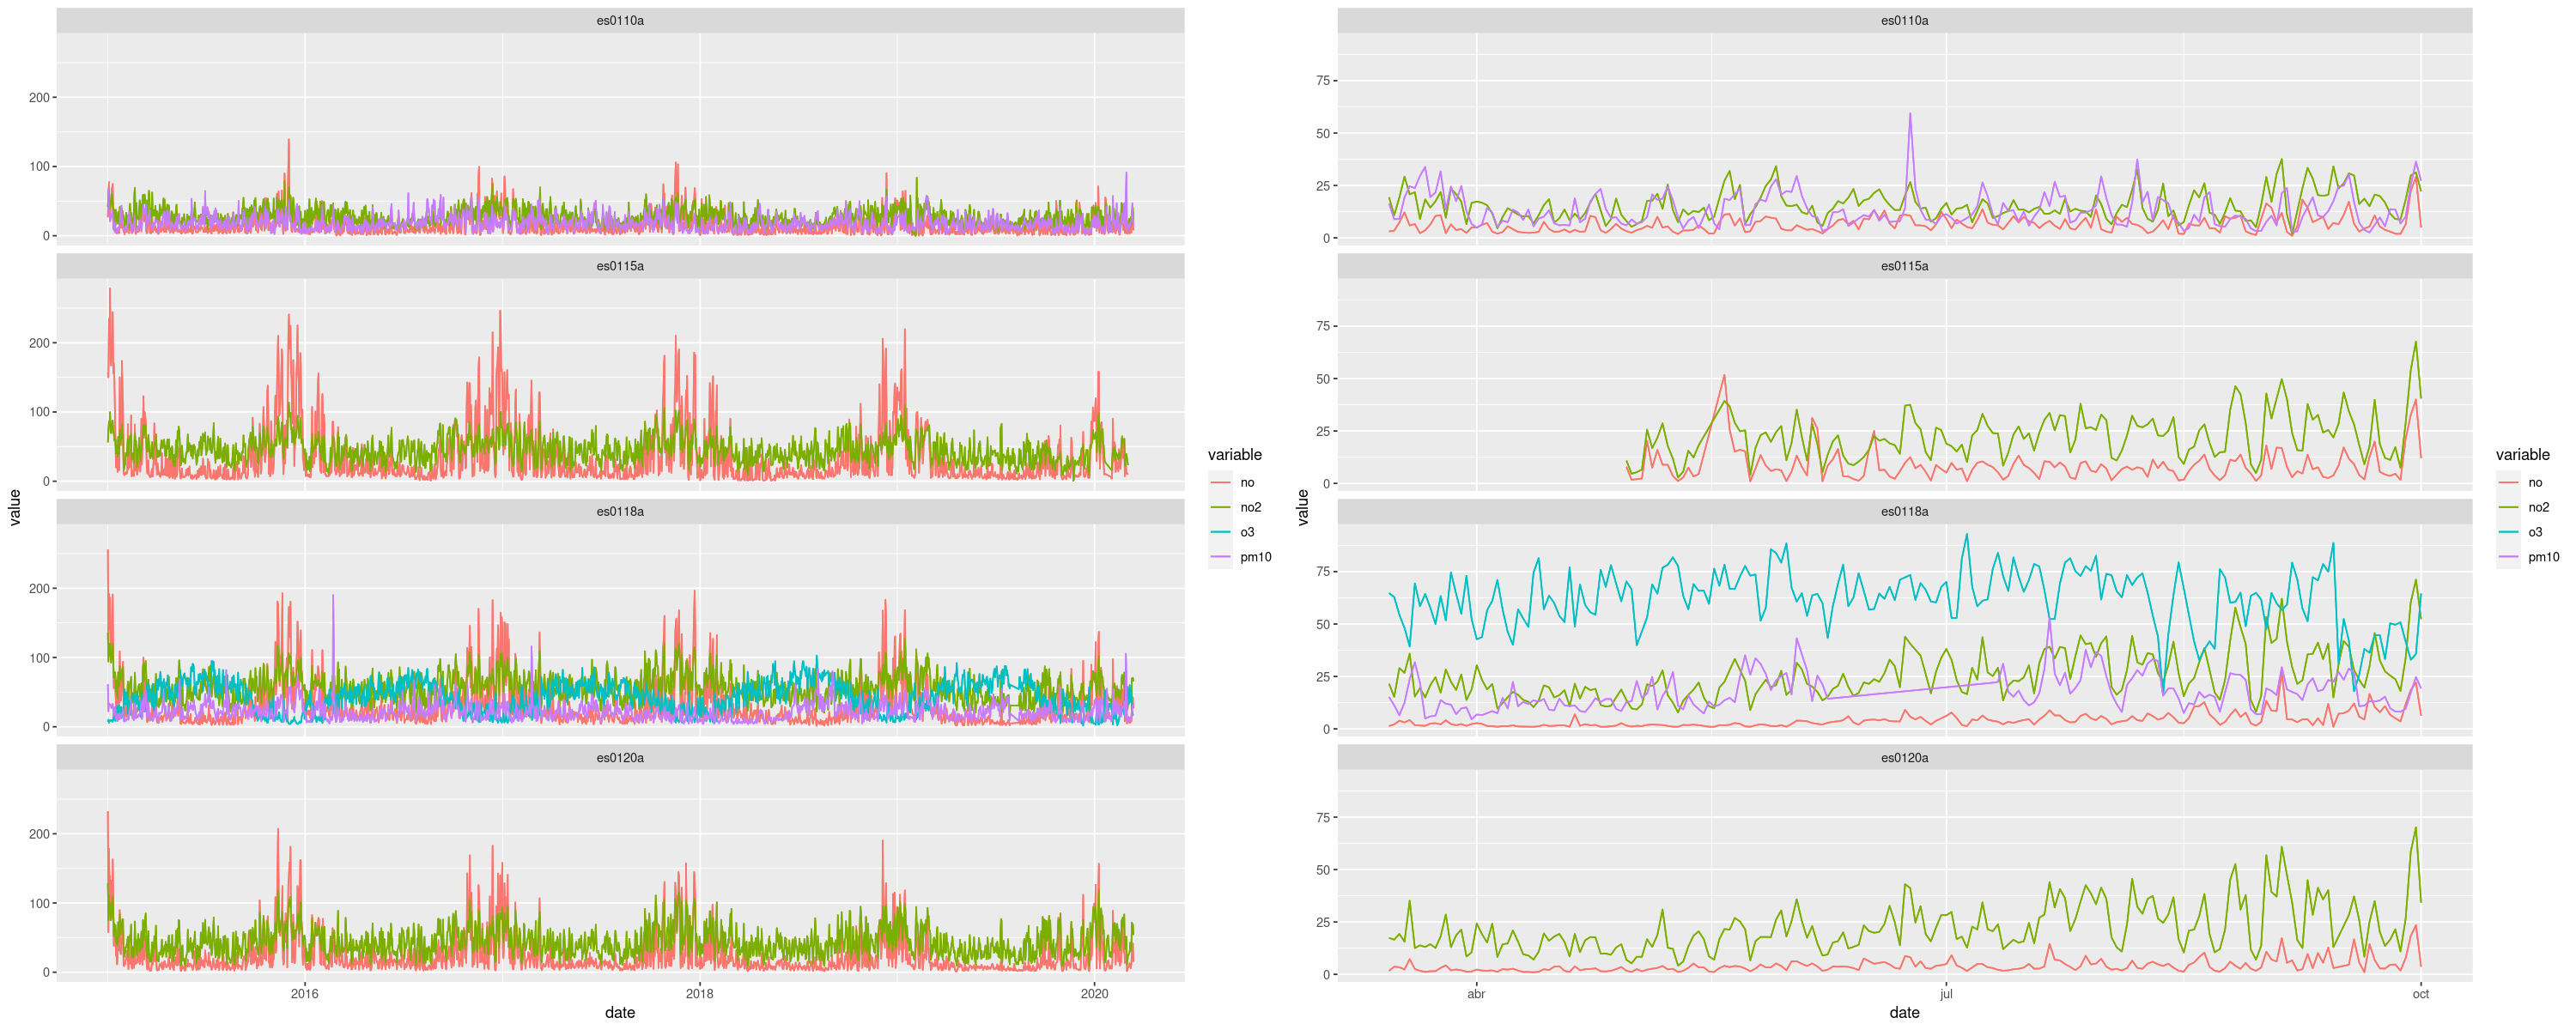

In [12]:
preCOVID <- ggplot(data = group.day[group.day$date < lckdwn_strt, ], 
                   aes(x = date, y = value, color=variable)
                  ) +
                geom_line() +
                geom_line() + 
                facet_wrap(~site, ncol=1)

COVID <- ggplot(data = group.day[group.day$date > lckdwn_strt, ],
                aes(x = date, y = value, color=variable)
               ) +
               geom_line() +
               geom_line() +
               facet_wrap(~site, ncol=1)
    
grid.arrange(preCOVID, COVID, nrow = 1)

#### Probando otra forma <a id="prueba"></a>

In [13]:
group.test.hr <- group.by.date(dataAQV, by="8hour", FUN="mean")

group.test.dy <- group.by.date(group.test.hr, by="day", FUN="max")

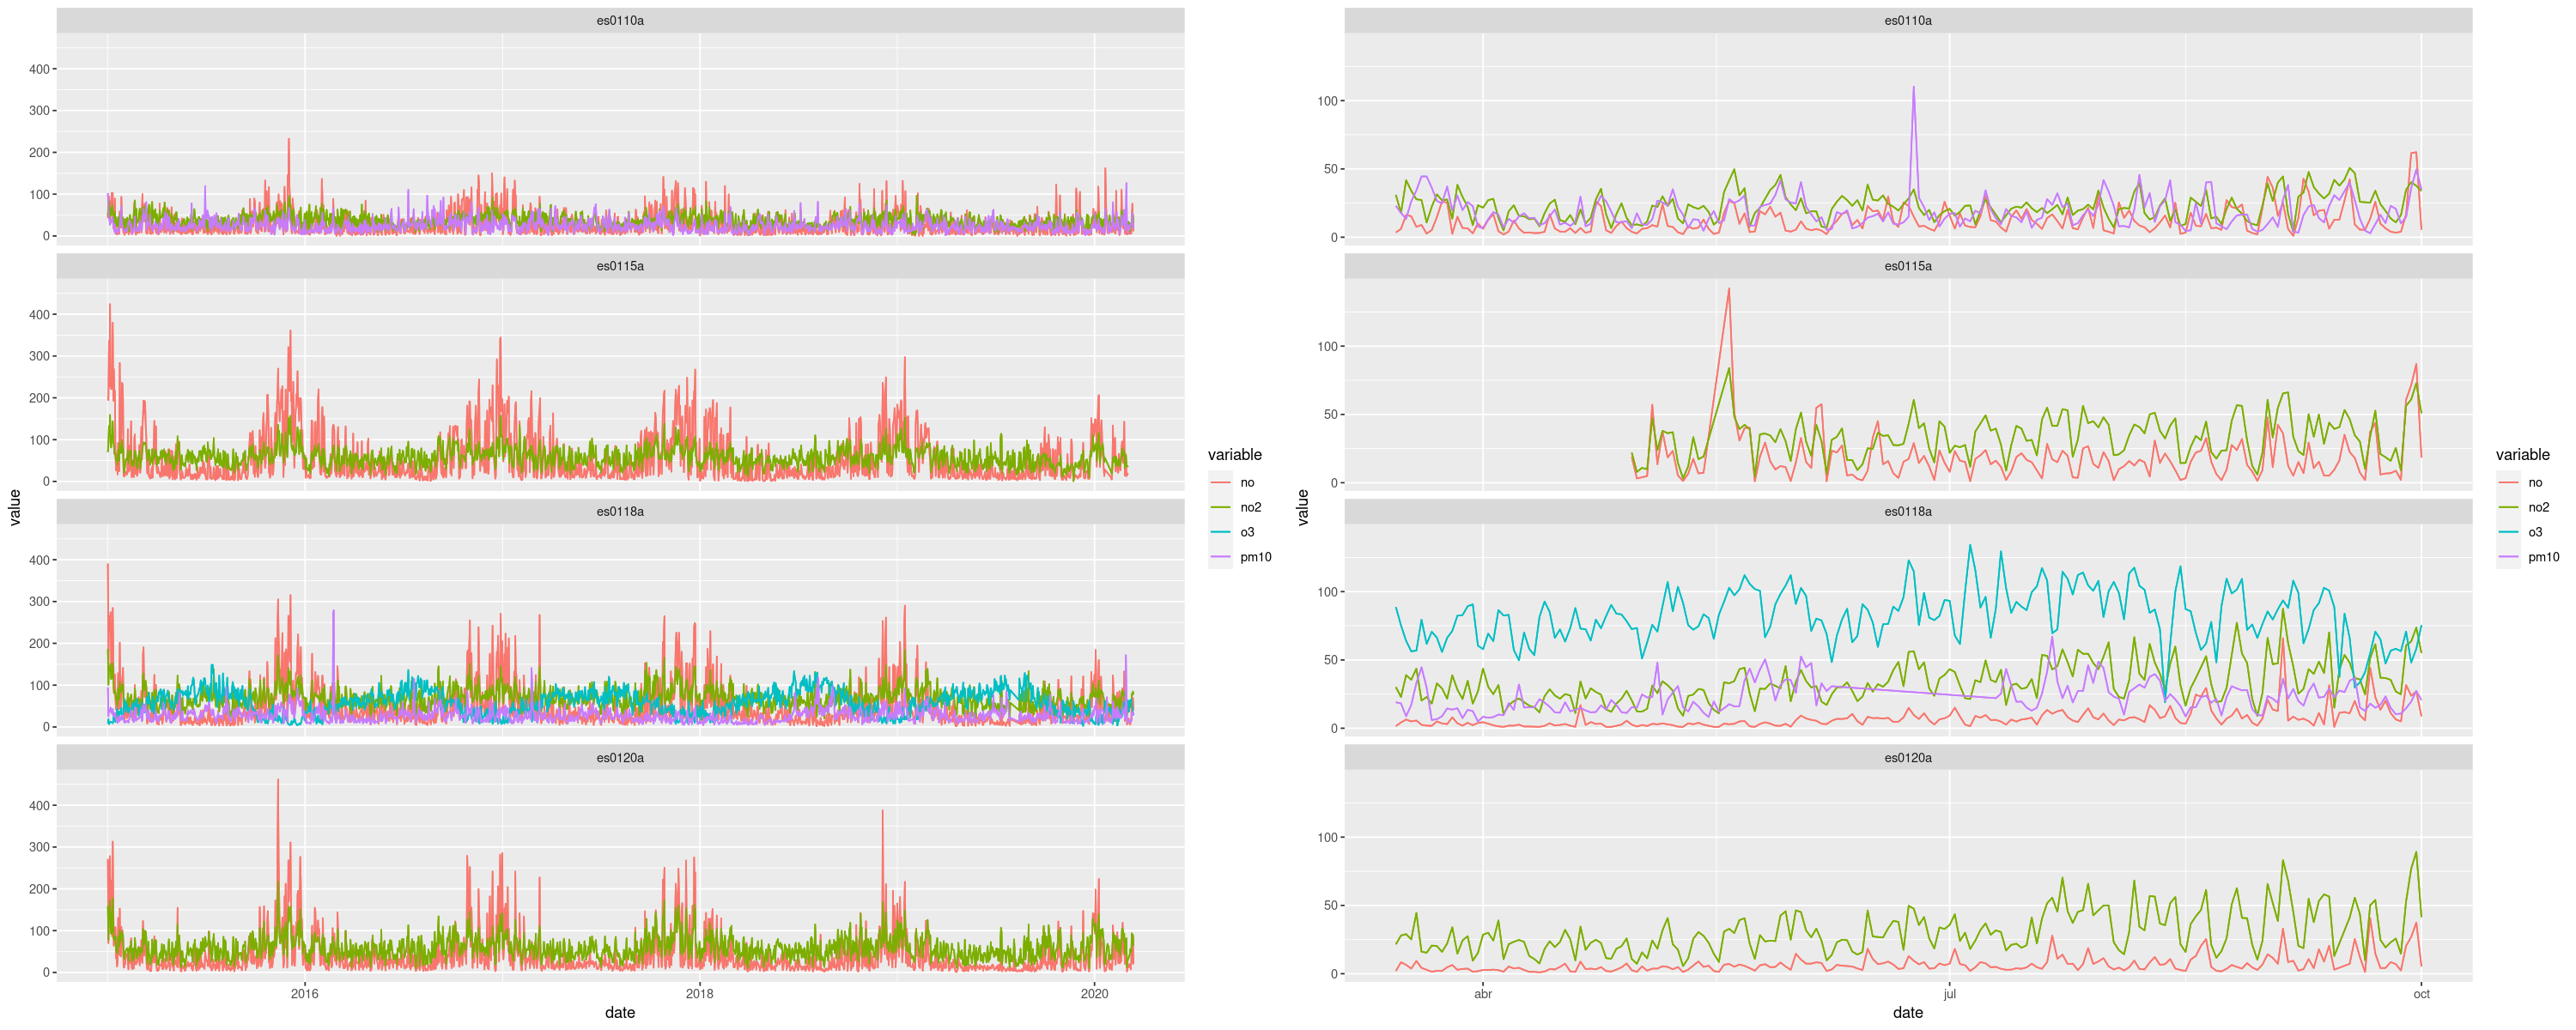

In [14]:
preCOVID <- ggplot(data = group.test.dy[group.test.dy$date < lckdwn_strt, ], 
                   aes(x = date, y = value, color=variable)
                  ) +
                geom_line() +
                geom_line() + 
                facet_wrap(~site, ncol=1)

COVID <- ggplot(data = group.test.dy[group.test.dy$date > lckdwn_strt, ],
                aes(x = date, y = value, color=variable)
               ) +
               geom_line() +
               geom_line() +
               facet_wrap(~site, ncol=1)
    
grid.arrange(preCOVID, COVID, nrow = 1)

### Resolucion de 1 semana <a id="resowk"></a>

In [15]:
group.wk <- group.by.date(dataAQV, by="week", FUN="mean")

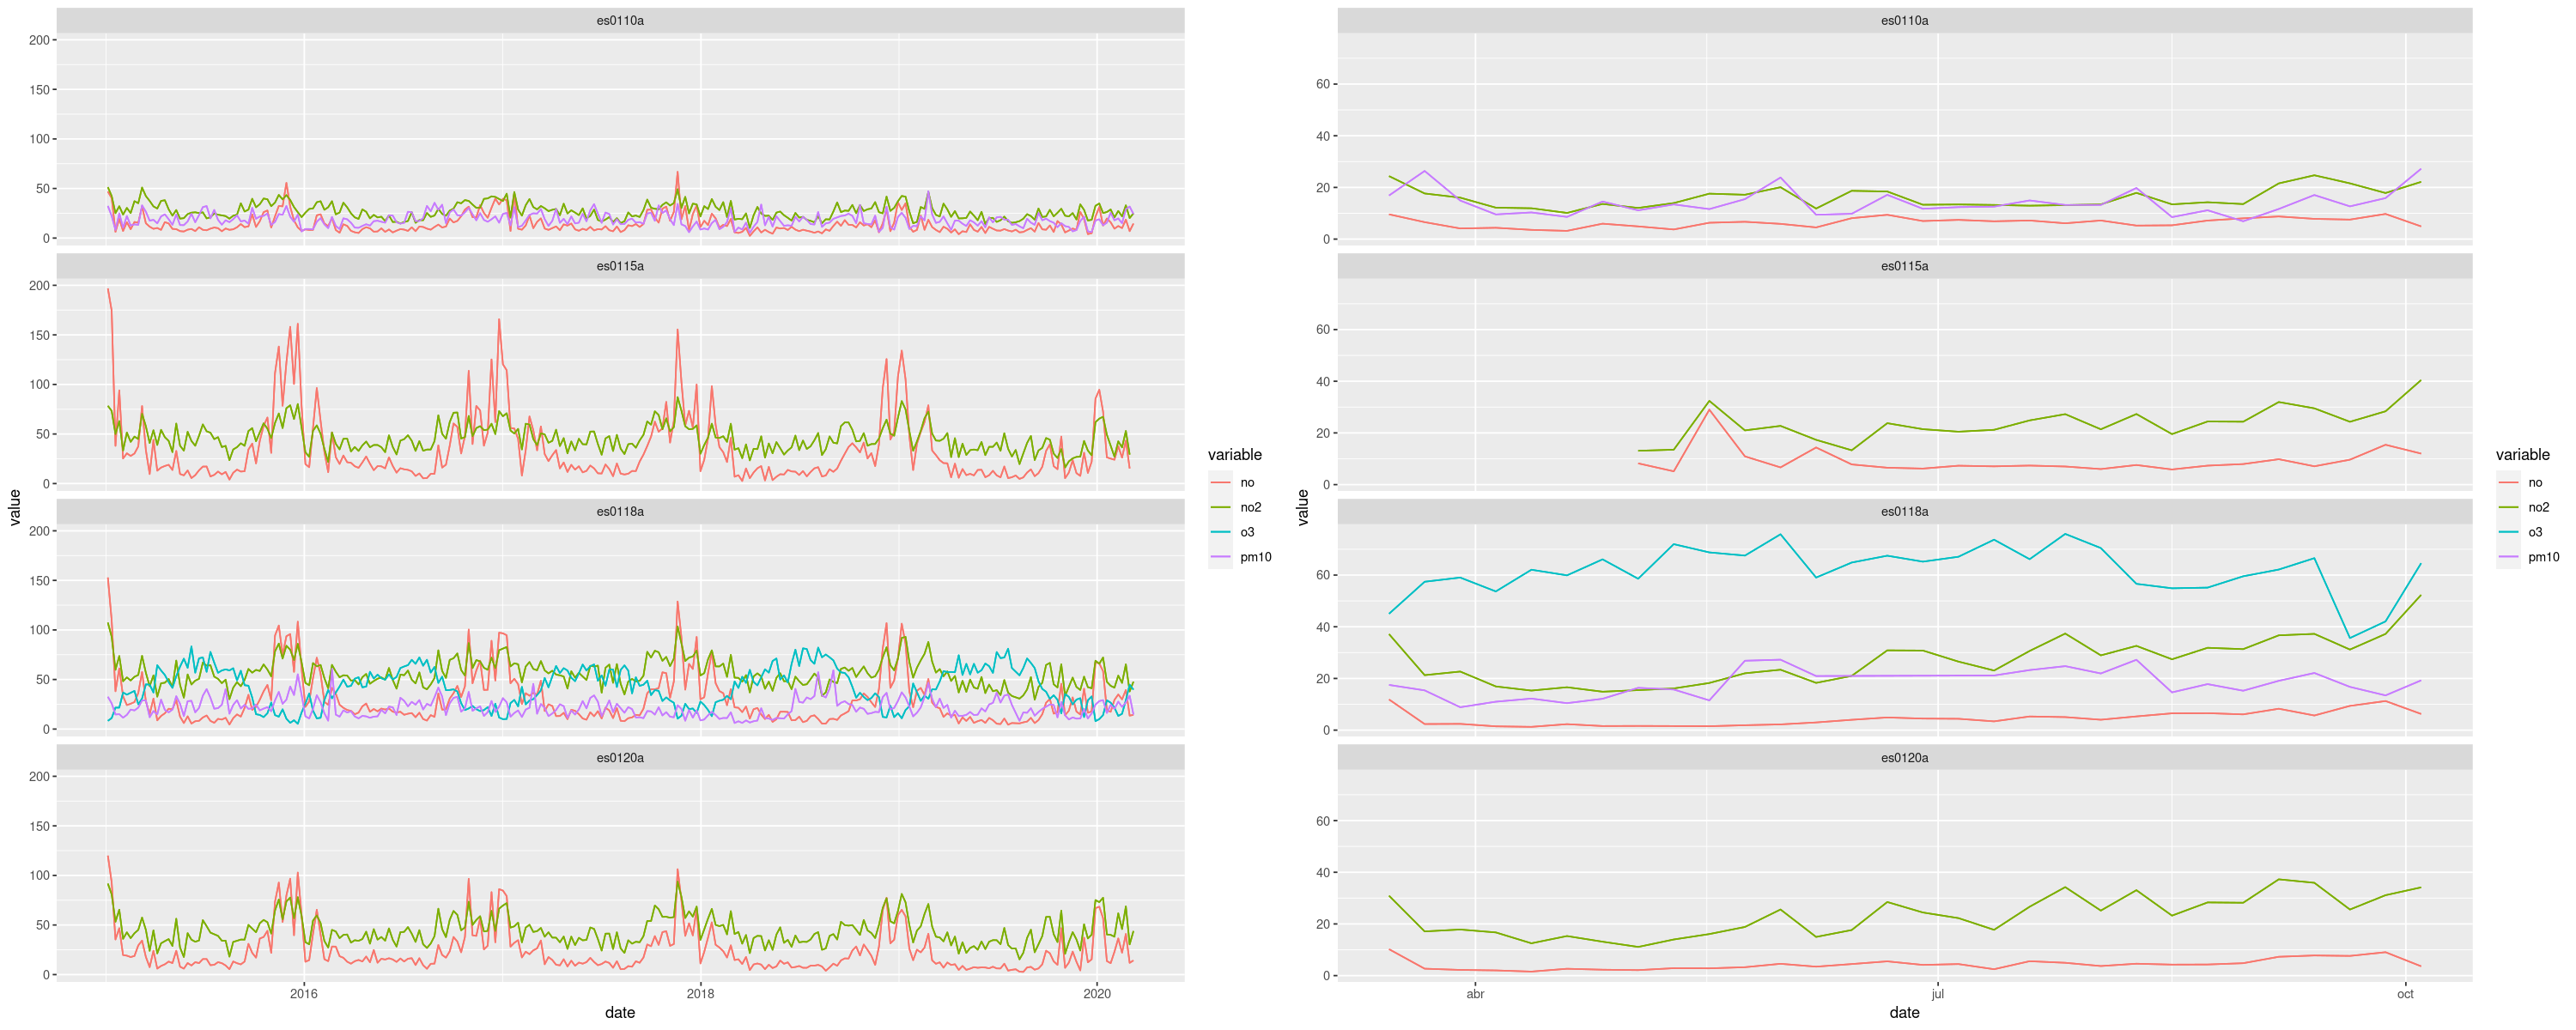

In [16]:
preCOVID <- ggplot(data = group.wk[group.wk$date < lckdwn_strt, ], 
                   aes(x = date, y = value, color=variable)
                  ) +
                geom_line() +
                geom_line() + 
                facet_wrap(~site, ncol=1)

COVID <- ggplot(data = group.wk[group.wk$date > lckdwn_strt, ],
                aes(x = date, y = value, color=variable)
               ) +
               geom_line() +
               geom_line() +
               facet_wrap(~site, ncol=1)
    
grid.arrange(preCOVID, COVID, nrow = 1)

### Resolucion de 1 mes <a id="resoms"></a>

In [17]:
group.mth <- group.by.date(dataAQV, by="month", FUN="mean")

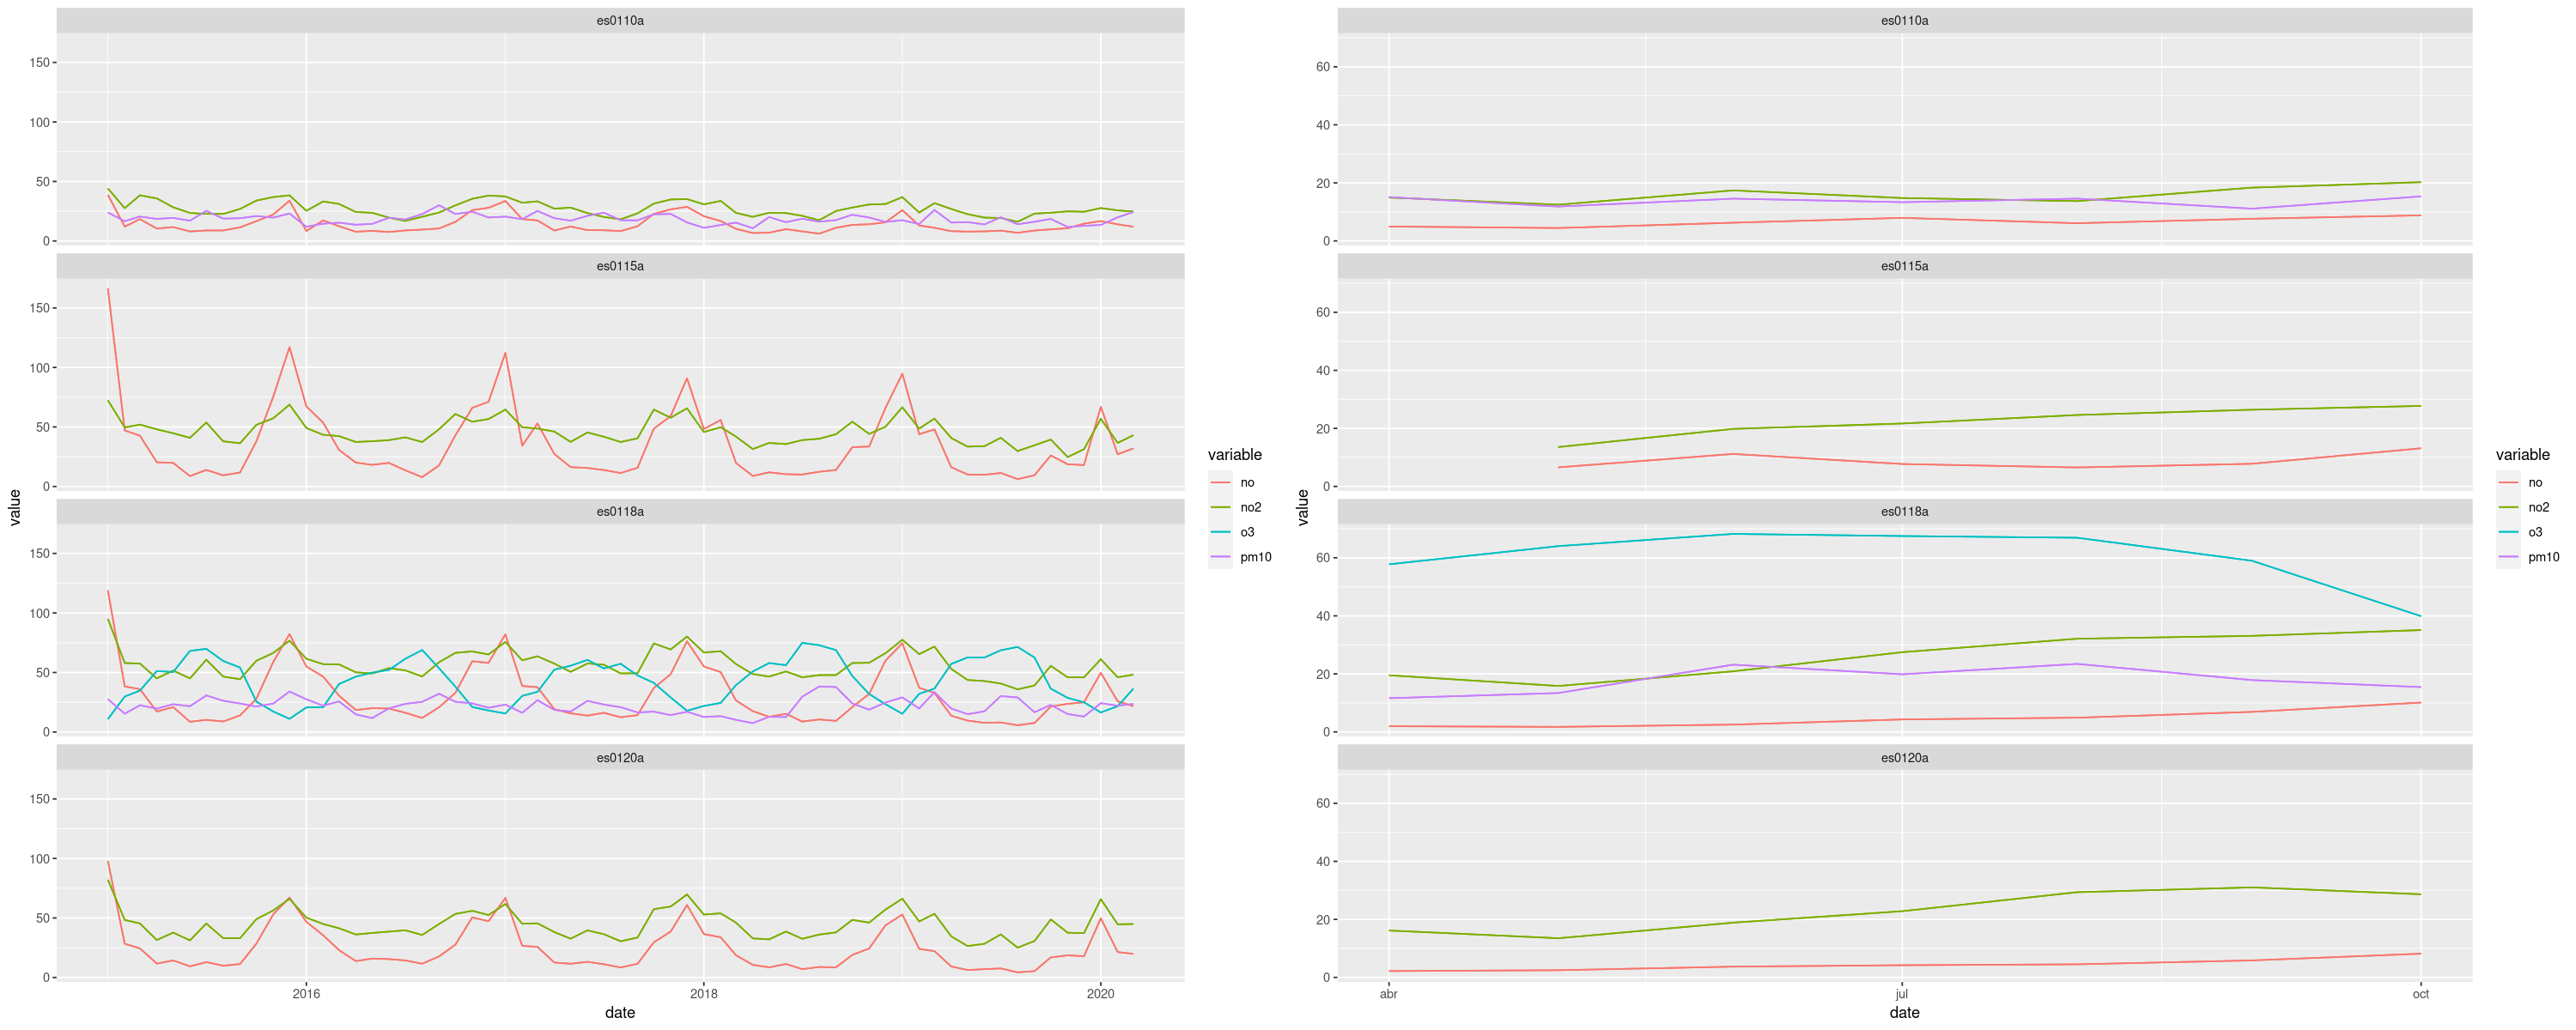

In [18]:
preCOVID <- ggplot(data = group.mth[group.mth$date < lckdwn_strt, ], 
                   aes(x = date, y = value, color=variable)
                  ) +
                geom_line() +
                geom_line() + 
                facet_wrap(~site, ncol=1)

COVID <- ggplot(data = group.mth[group.mth$date > lckdwn_strt, ],
                aes(x = date, y = value, color=variable)
               ) +
               geom_line() +
               geom_line() +
               facet_wrap(~site, ncol=1)
    
grid.arrange(preCOVID, COVID, nrow = 1)

## Analisis de los Datos <a id="analyData"></a>

Se aplican algunas funciones propias de `R` para mostrar el potencial de los datos combinandolos con paquetes estadisticos existentes

### Theil-Sen function <a id="theilSen"></a>

Se comparan las graficas obtenidas mediante la funcion propia de `Openair` para el estimador Theil-Sein y las obtenidas mediante otro metodo externo.

In [19]:
test.theilSen <- pivot.by.pollut(dataAQV, 
                             pollutants=pollutants, 
                             by="week",
                             #site=sites$site[3]
                            )

test.theilSen$fit <- rep(0, nrow(test.theilSen))
for (site in levels(as.factor(test.theilSen$site))) {

    fit <- mblm(no2 ~ id + 1, 
                test.theilSen[test.theilSen$site == site, ], 
                repeated=T)
    test.theilSen[test.theilSen$site == site, ]$fit <- fit$fitted.values
}

Warning message:
“`group_by_()` is deprecated as of dplyr 0.7.0.
Please use `group_by()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
Warning message:
“`summarise_each_()` is deprecated as of dplyr 0.7.0.
Please use `across()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
Warning message:
“`funs()` is deprecated as of dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


[1] "Taking bootstrap samples. Please wait."
[1] "Taking bootstrap samples. Please wait."
[1] "Taking bootstrap samples. Please wait."
[1] "Taking bootstrap samples. Please wait."


Warning message:
“`distinct_()` is deprecated as of dplyr 0.7.0.
Please use `distinct()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


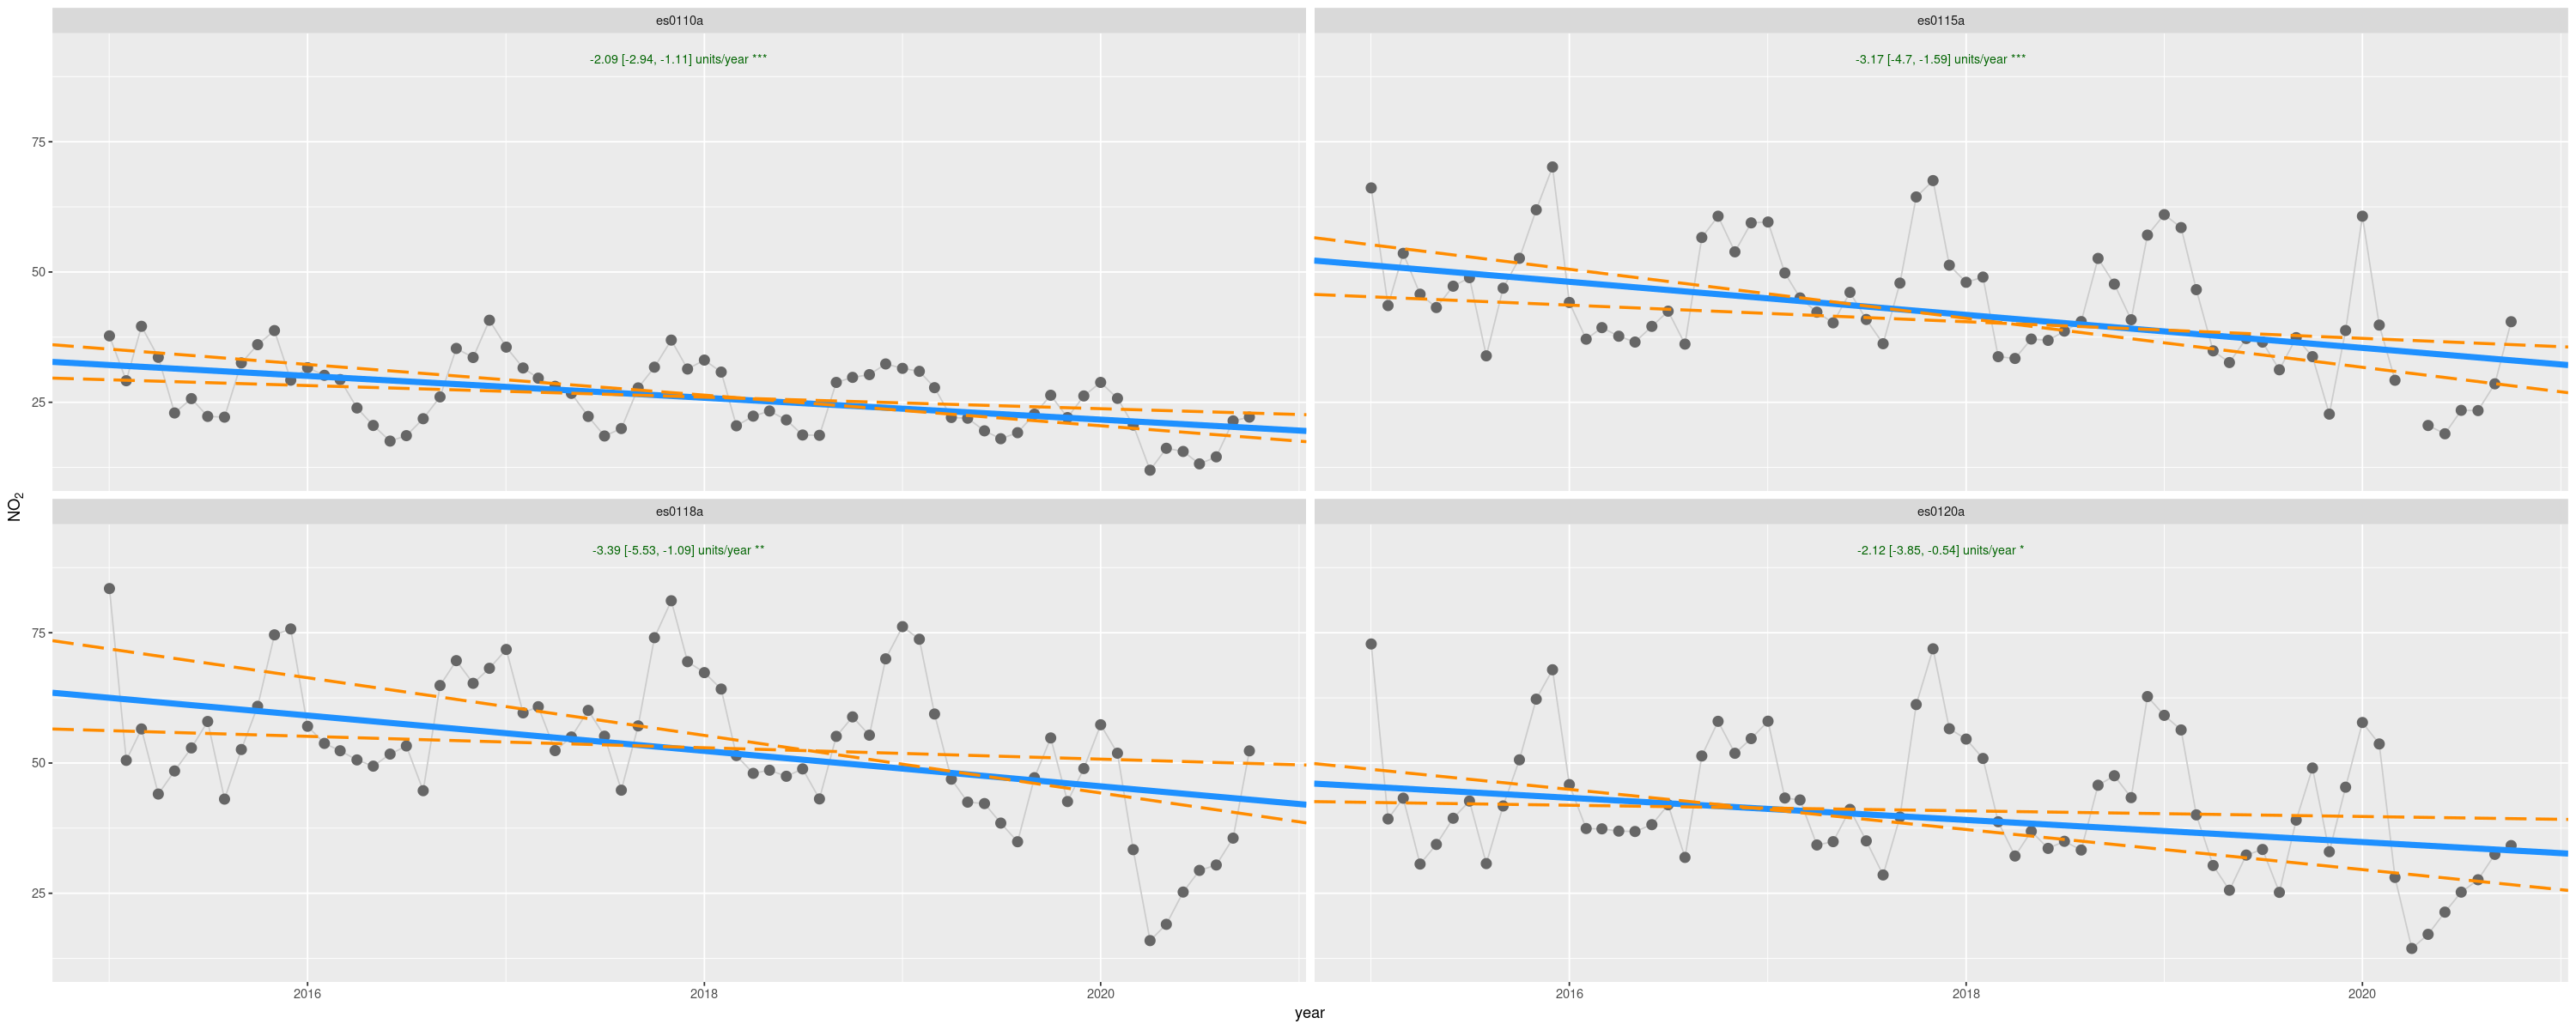

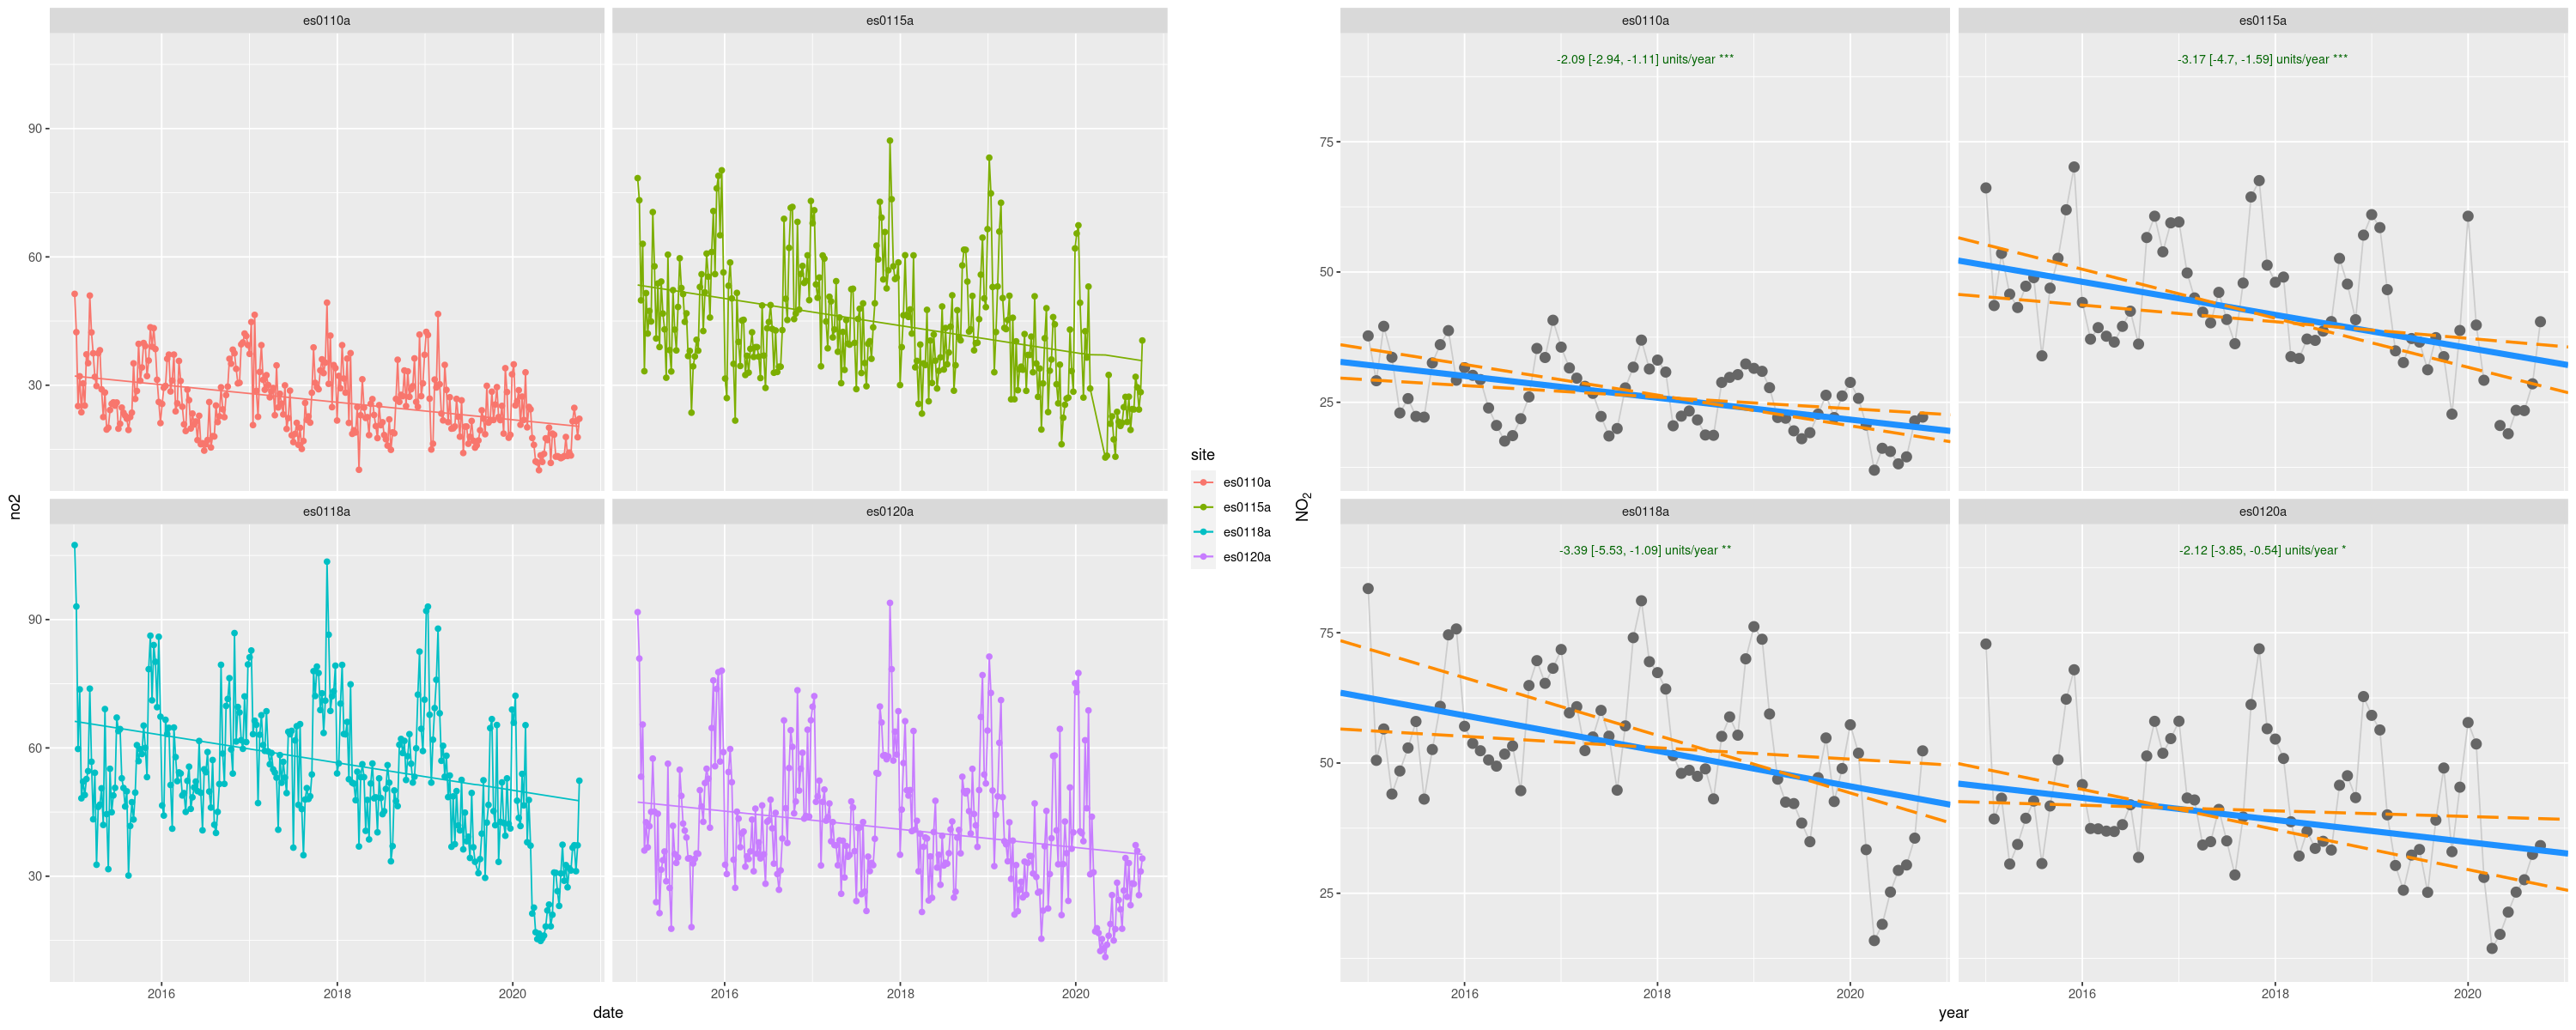

In [20]:
my.plt <- ggplot(data=test.theilSen, aes(x=date)) +
                geom_point(aes(y=no2, color=site)) +
                geom_line(aes(y=no2, color=site)) +
                geom_line(aes(y=fit, color=site))  +
                facet_wrap(~site)

theil.plt <- suppressMessages(TheilSen(test.theilSen,
                                       deseason = F,
                                       pollutant = "no2", 
                                       #site=sites$site[3],
                                       avg.time = "month",
                                       type="site",
                                      )
                              )


grid.arrange(my.plt, theil.plt$plot, nrow = 1)

### Funcion `lm` <a id="lm"></a>

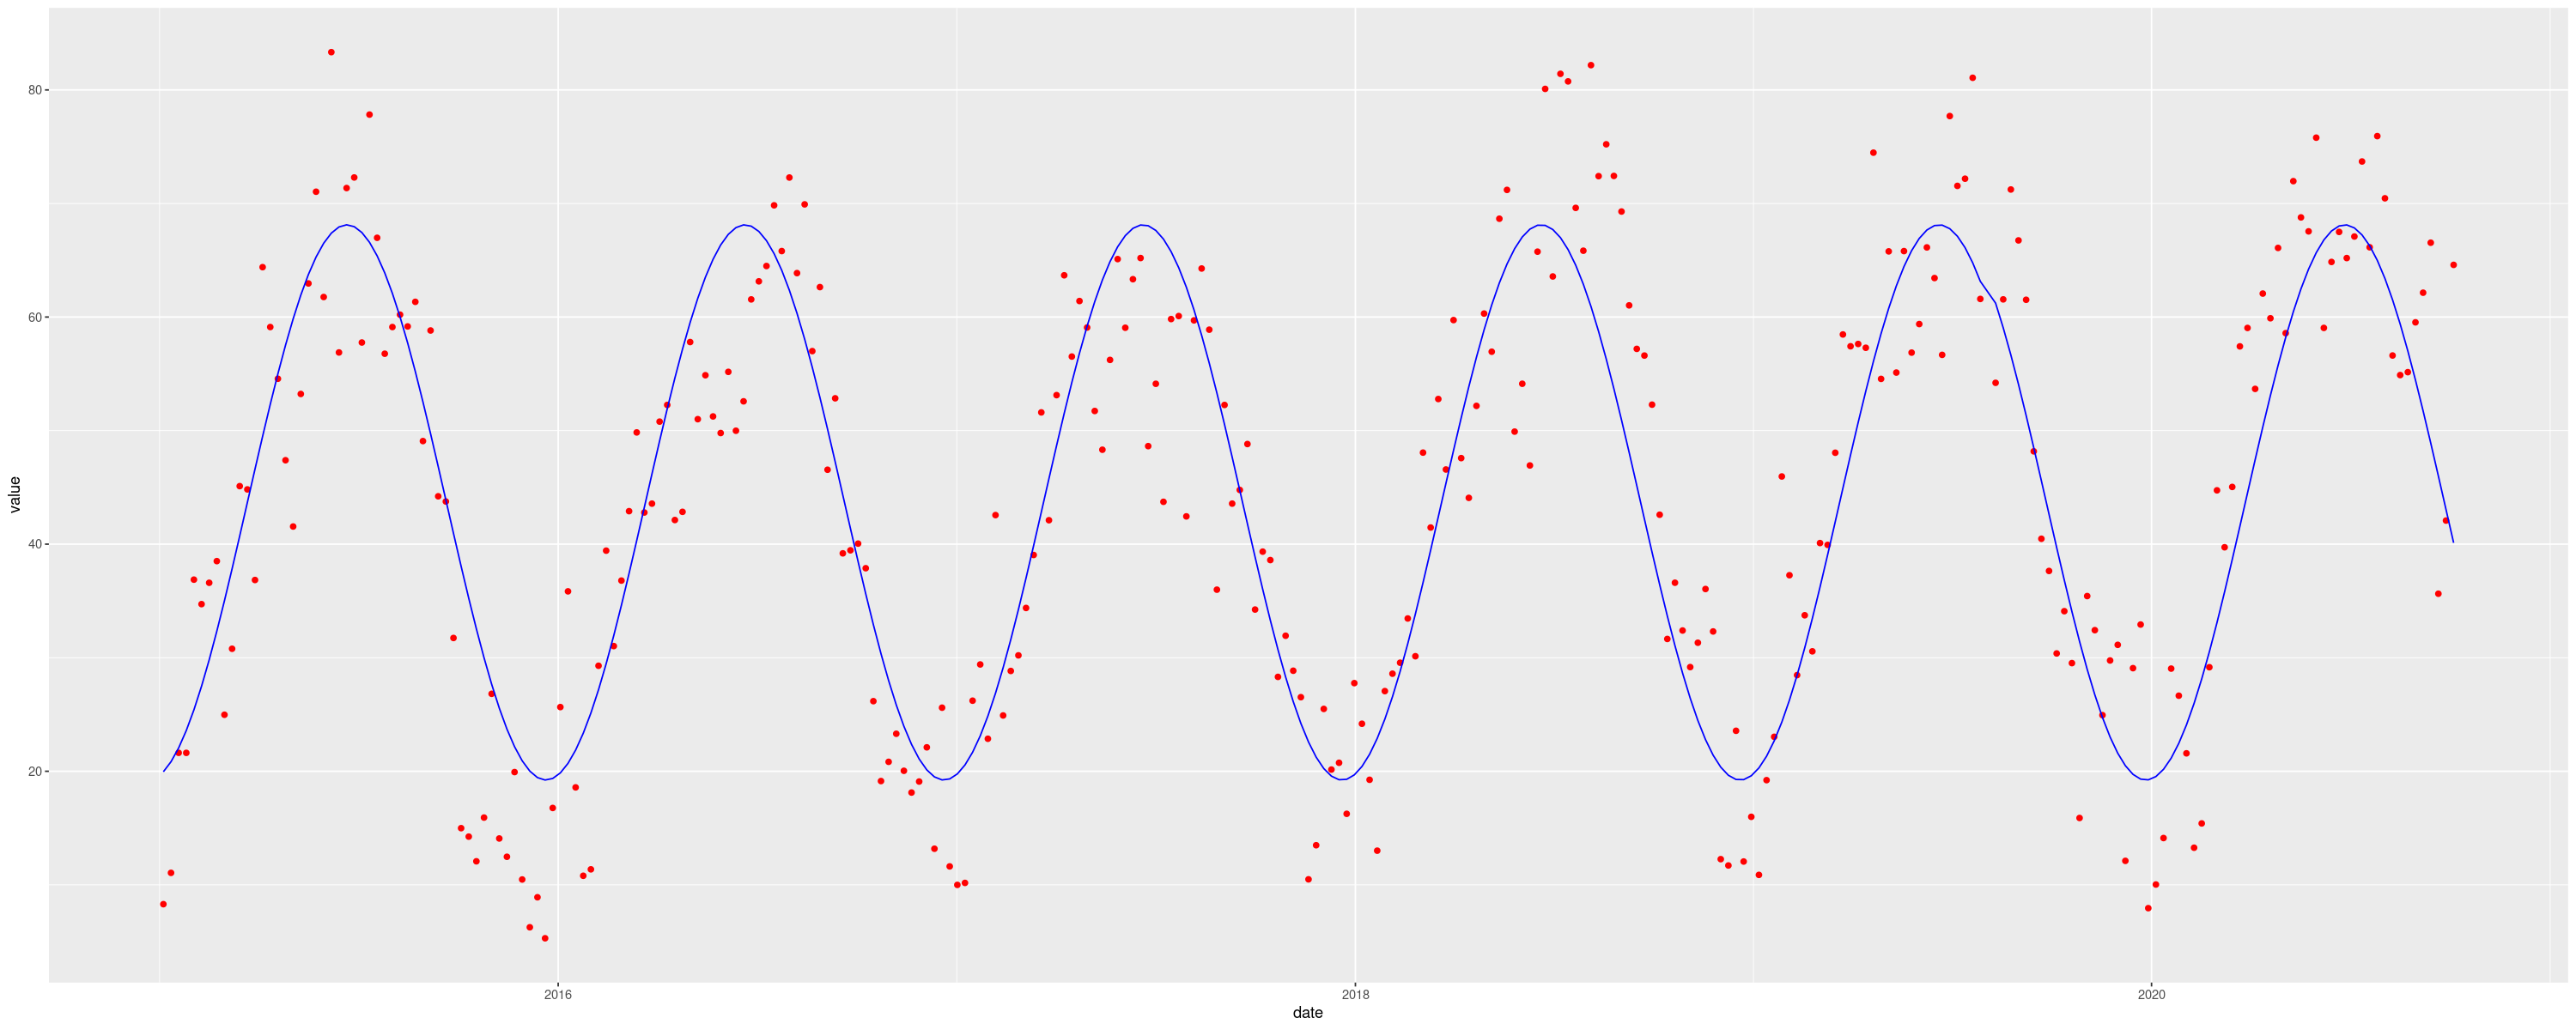

In [21]:
data.lm <- group.wk[group.wk$site ==  "es0118a"
                    & group.wk$variable == "o3",][ c("value", "date")]
data.lm["id"] <- seq.int(nrow(data.lm))

lm.fit <- lm(value ~ sin(2*pi/(1*52.1429)*id)+cos(2*pi/(1*52.1429)*id), 
                data=data.lm)

ggplot() + 
        geom_point(data=data.lm, aes(x=date, y=value), color="red") +
        geom_line(aes(x=data.lm$date, y=lm.fit$fitted.values), color="blue")

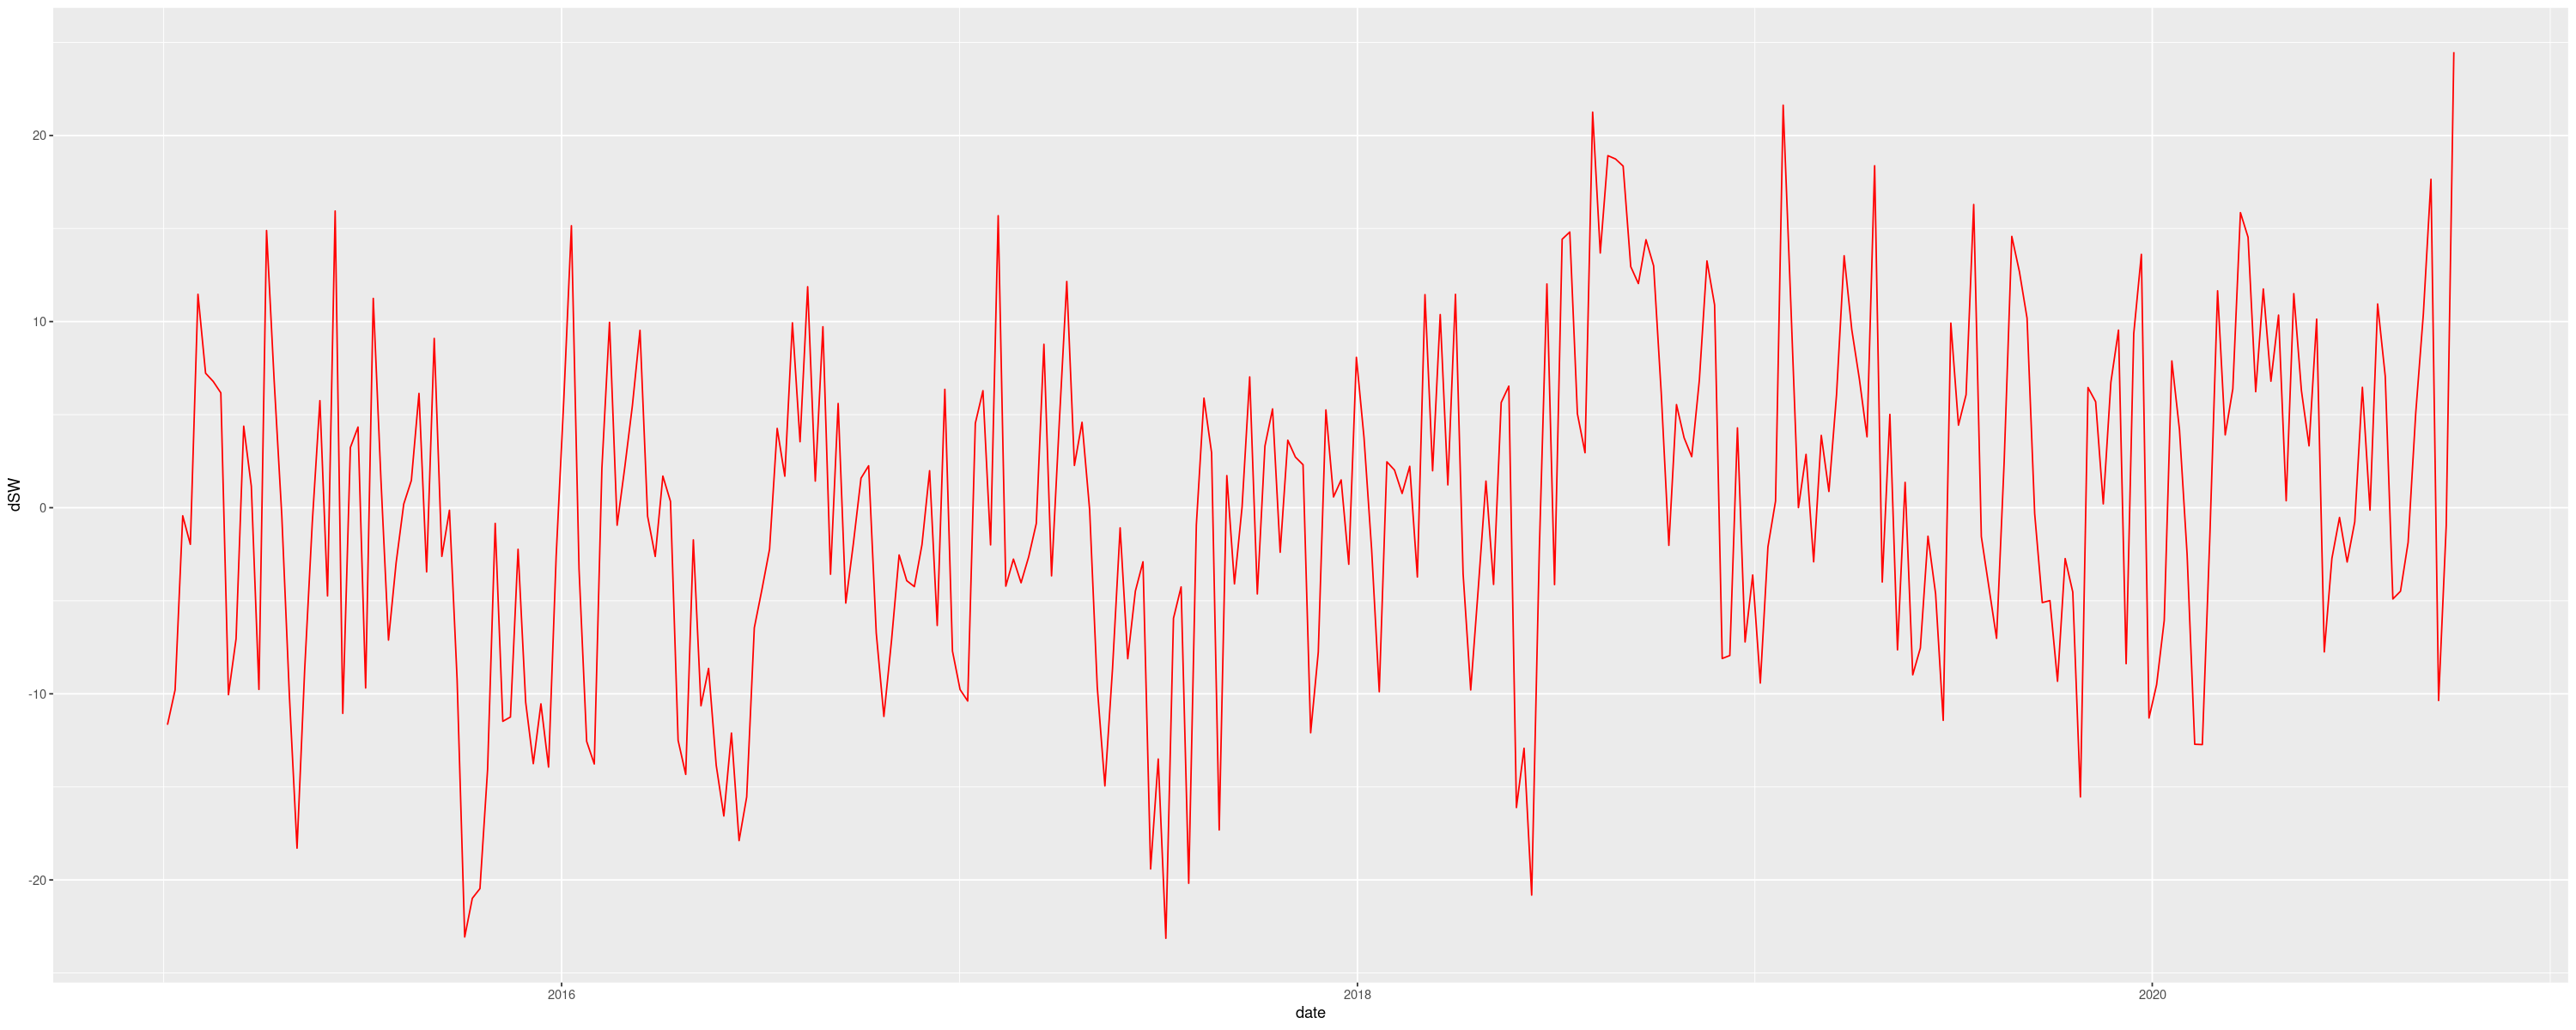

In [23]:
data.lm$dSW <- data.lm$value - lm.fit$fitted.values

ggplot() + 
        geom_line(data=data.lm, aes(x=date, y=dSW), color="red")

## Guardar Datos en xlsx <a id="save"></a>

``` R
write.csv(dataAQV, "../data/csv/dataAQV.csv")
write.csv(sites, "../data/csv/estaciones.csv")
```